In [1]:
# Team 8
# Name: Can Wang, Kaisheng Su, Mingtao Yang, Zhihe Ping
# Student number:1176867, 1241049, 1527052, 1238760
import json
import requests
import pandas as pd

In [17]:
# Repeat to run this block of code until there is no error message printed
response = requests.get("http://127.0.0.1:9090/EPA/air-quality-death")
if response.status_code == 200:
    data = response.json().get('data')
else:
    print(response.text)

Average values of polutions in Public Health Network (PHN) areas in Victoria 

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.json_normalize(data) 


features = ['Particles', 'PM2.5', 'PM10', 'Visibility', 'API', 'O3', 'NO2', 'SO2', 'CO']


for feature in features:
    df[feature+'_mean'] = df[feature].apply(lambda x: sum(filter(None, x))/len(x) if isinstance(x, list) and any(x) else None)

# Delete the original feature columns
df.drop(columns=features, inplace=True)
df.dropna(how='all', subset=df.columns[5:], inplace=True)
df.drop(columns=['_id'],inplace=True)

phn_codes = list(df['phn_code'])
df

,resp_death_ratio,lung_death_ratio,phn_code,phn_name,Particles_mean,PM2.5_mean,PM10_mean,Visibility_mean,API_mean,O3_mean,NO2_mean,SO2_mean,CO_mean
10,0.000134,0.000199,PHN201,North Western Melbourne,8.508250,10.296638,20.256413,64.932862,0.821630,7.940000,12.043478,0.426739,0.503478
11,0.000092,0.000152,PHN202,Eastern Melbourne,8.253768,11.012500,14.584565,61.843696,0.788913,NaN,NaN,NaN,NaN
12,0.000120,0.000191,PHN203,South Eastern Melbourne,NaN,10.972283,14.195217,64.876739,0.708913,8.186522,NaN,NaN,NaN
13,0.000147,0.000236,PHN204,Gippsland,7.247003,3.952500,7.898087,66.426957,0.429638,15.774783,4.022065,0.419130,0.120000
14,0.000178,0.000230,PHN205,Murray,7.560605,4.347283,11.367935,NaN,NaN,NaN,NaN,NaN,NaN
15,0.000178,0.000219,PHN206,Western Victoria,9.863231,5.971739,16.650000,63.855000,0.518478,4.860435,7.891304,0.166304,0.143696


Visualize air quality index

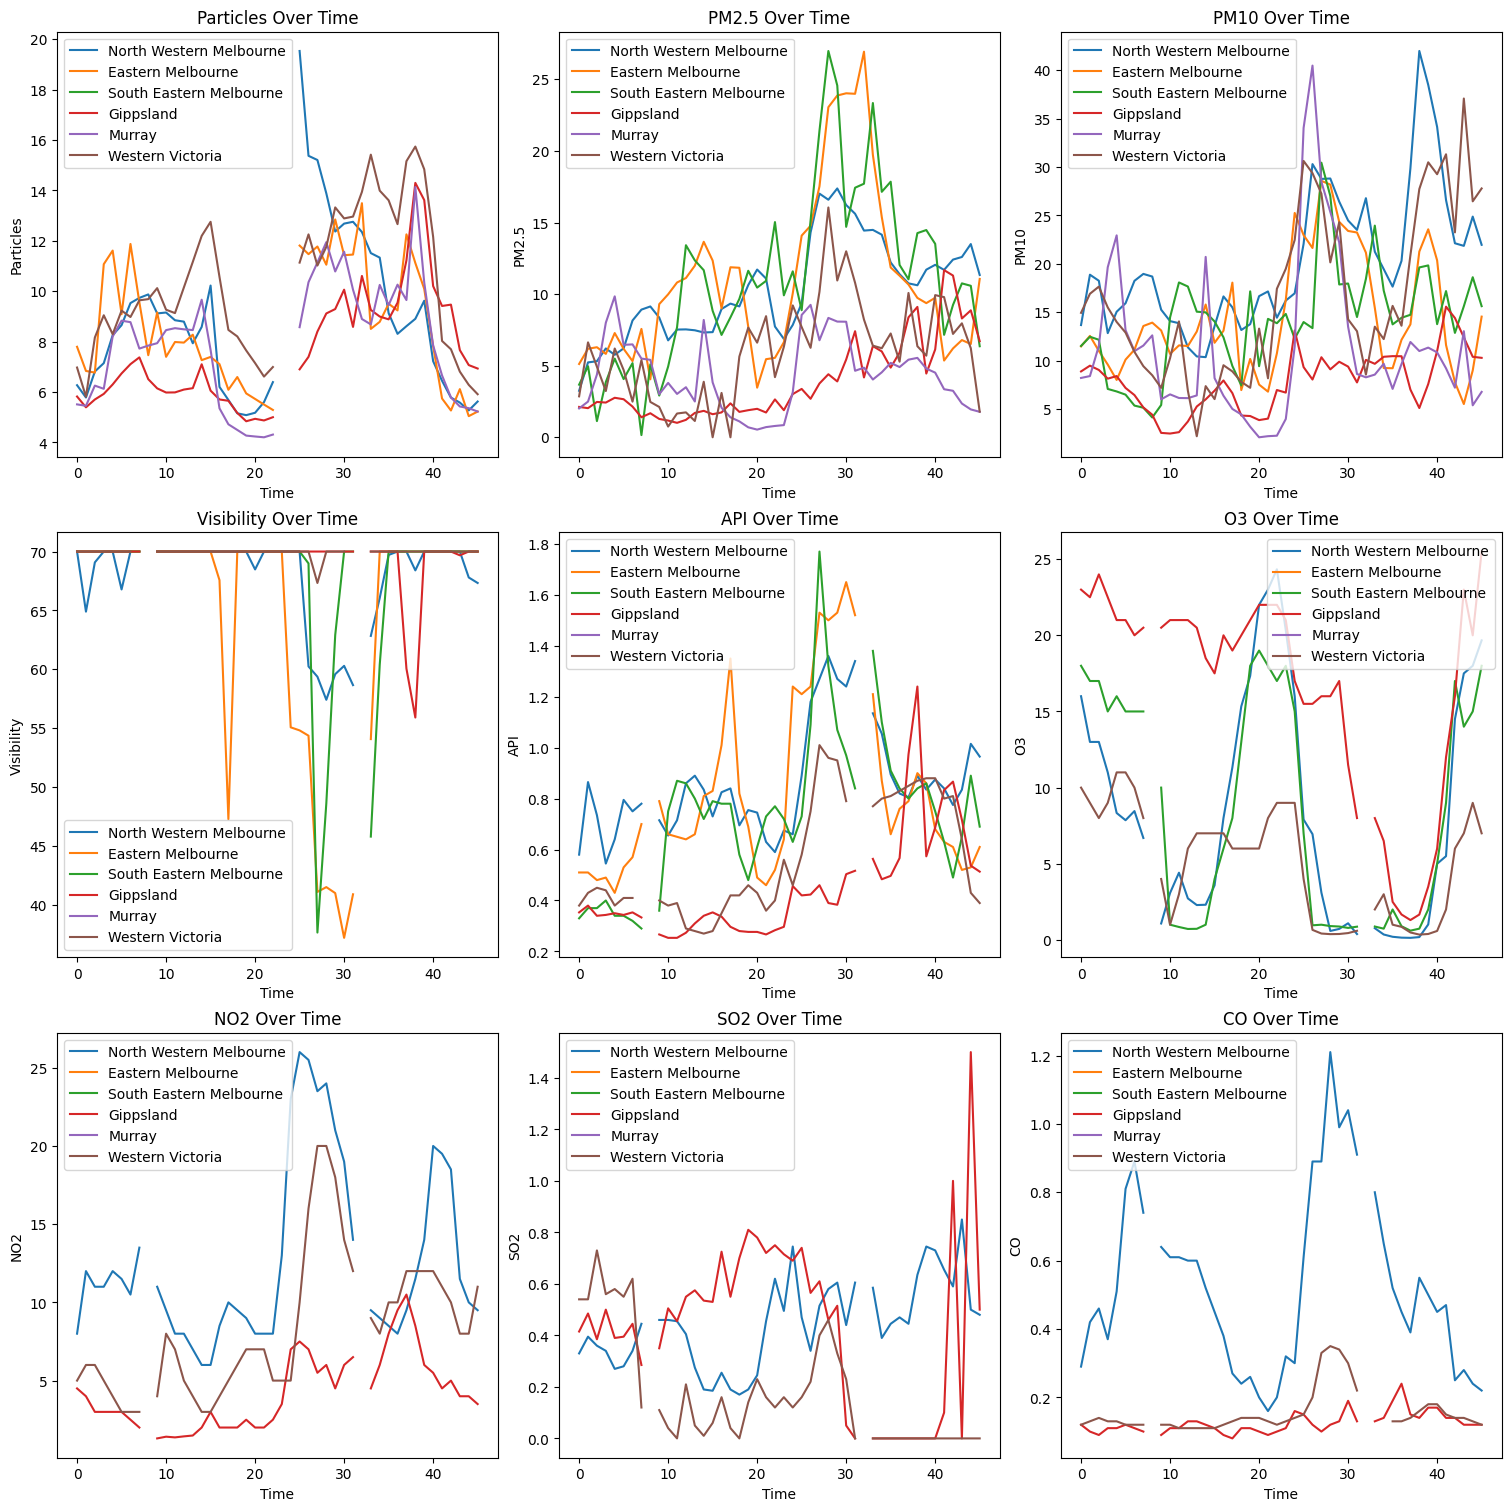

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.json_normalize(data) 

features = ['Particles', 'PM2.5', 'PM10', 'Visibility', 'API', 'O3', 'NO2', 'SO2', 'CO']
fig, axes = plt.subplots(3, 3, figsize=(15, 3 * 5), constrained_layout=True)
df.replace('None', np.nan, inplace=True)

# Make a line graph for each air pollutant
for idx, feature in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    for row_idx, row in df.iterrows():
        if isinstance(row[feature], list) and row['phn_code'] in phn_codes:  
            ax.plot(range(len(row[feature])), row[feature], label=row['phn_name'])
    ax.set_title(f'{feature} Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel(feature)
    ax.legend()

plt.show()

Analyse the relationship between respiratory disease death ratio and air pollutants

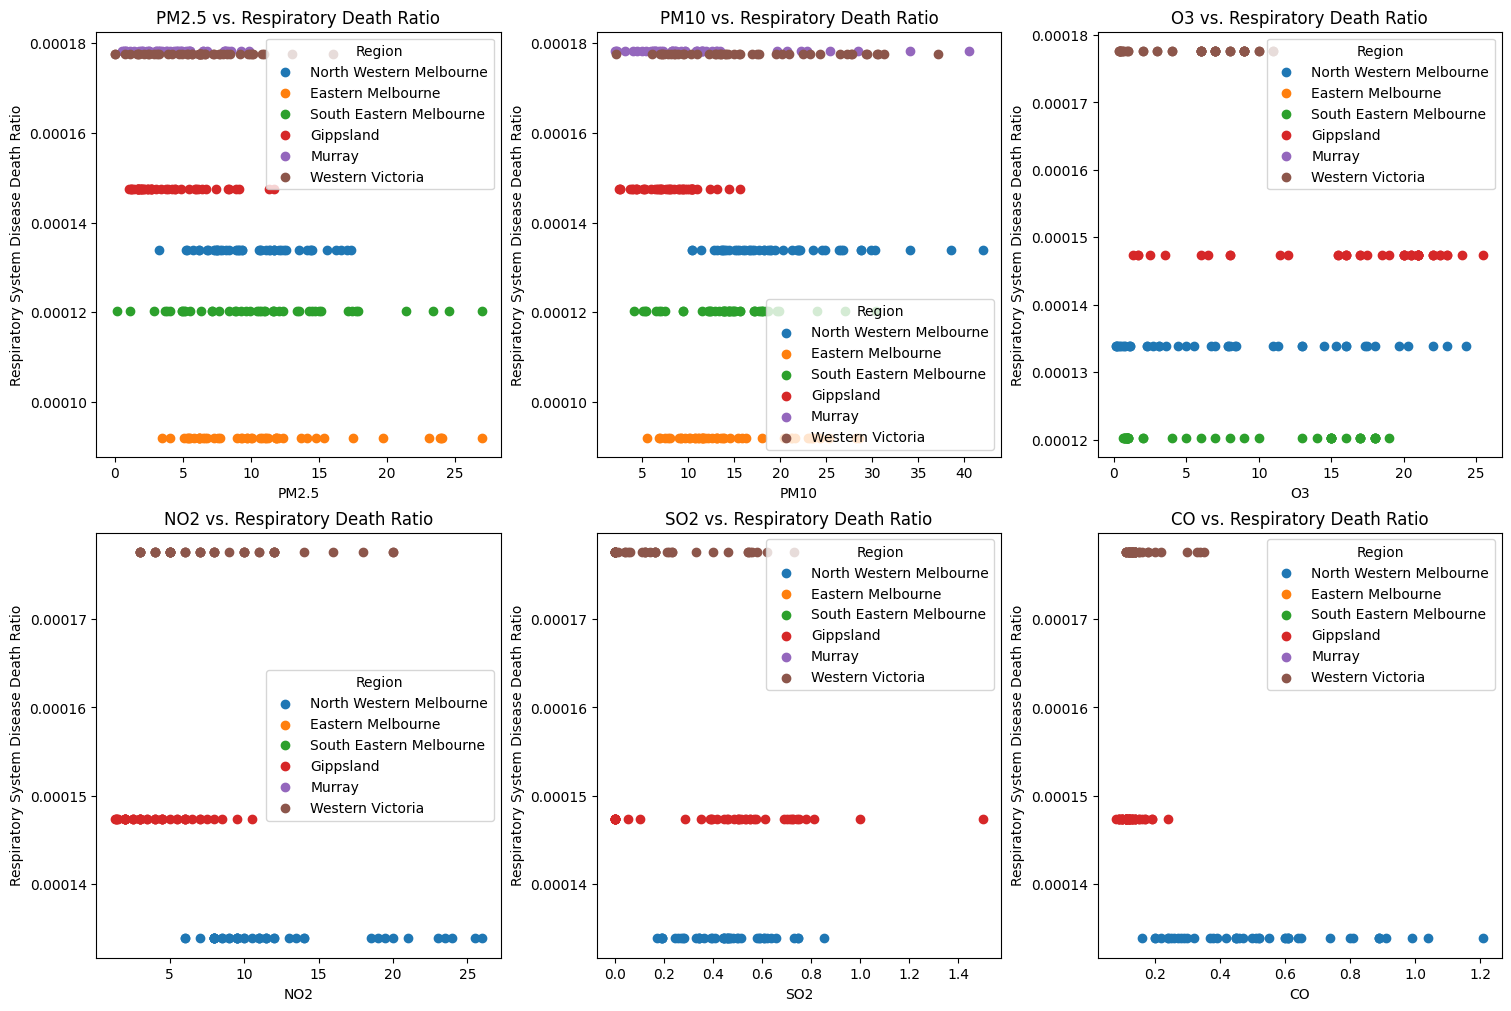

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.json_normalize(data)

features = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
df.replace('None', np.nan, inplace=True)

# create a maapping of phn_code and phn_name
phn_code_to_name = {row['phn_code']: row['phn_name'] for _, row in df.iterrows()}

for idx, feature in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    for phn_code in phn_codes:
        region_data = df[df['phn_code'] == phn_code]
        all_pollution_values = []
        all_death_ratios = []

        for row_idx, row in region_data.iterrows():
            if isinstance(row[feature], list):
                # Filter out the None values
                pollution_values = [value for value in row[feature] if value is not None]
                # make a death ratio lists with the same length of pollution_values
                death_ratios = [row['resp_death_ratio']] * len(pollution_values)

                all_pollution_values.extend(pollution_values)
                all_death_ratios.extend(death_ratios)

        valid_indices = [i for i, x in enumerate(all_pollution_values) if np.isfinite(x) and np.isfinite(all_death_ratios[i])]
        all_pollution_values = [all_pollution_values[i] for i in valid_indices]
        all_death_ratios = [all_death_ratios[i] for i in valid_indices]

        # Draw the scatter plot
        phn_name = phn_code_to_name.get(phn_code, 'Unknown')  
        ax.scatter(all_pollution_values, all_death_ratios, label=phn_name)
    
    ax.set_title(f'{feature} vs. Respiratory Death Ratio')
    ax.set_xlabel(feature)
    ax.set_ylabel('Respiratory System Disease Death Ratio')
    ax.legend(title="Region")

plt.show()


Correlation matrix to analyse the relativity of different pollutant with the respiratory system mortality

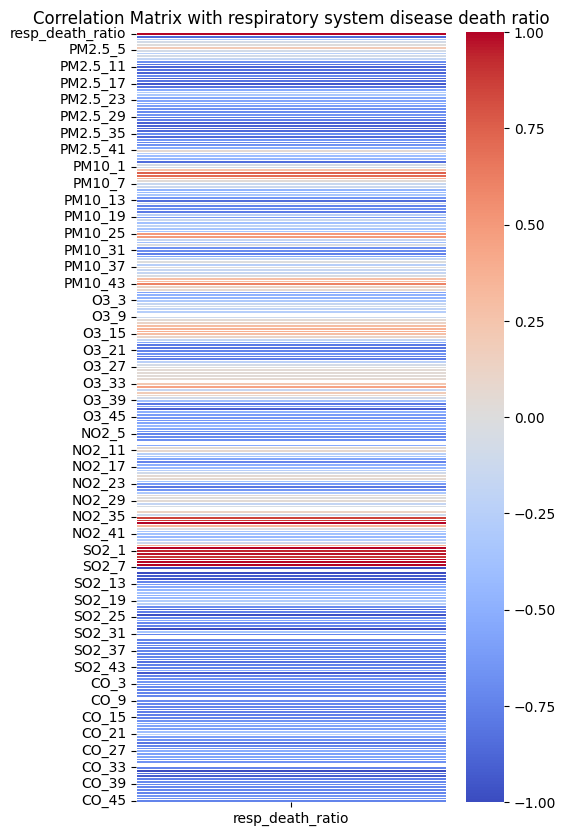

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.json_normalize(data) 


features = ['Particles', 'PM2.5', 'PM10', 'Visibility', 'API', 'O3', 'NO2', 'SO2', 'CO']
pollutant_features = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']

# make all the values in the list be seperate columns in the dataframe
for feature in pollutant_features:
    df = pd.concat([df, df[feature].apply(pd.Series).add_prefix(feature+'_')], axis=1)

# Drop the original columns of featuers
df.drop(columns=features, inplace=True)

df = df.dropna(subset=df.columns[4:], how='all')

df = df.drop(columns=['_id','phn_code', 'phn_name','lung_death_ratio'])
correlation_matrix = df.corr()
# Draw the correlation matrix
plt.figure(figsize=(5, 10))
sns.heatmap(correlation_matrix[['resp_death_ratio']], annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix with respiratory system disease death ratio")
plt.show()



Analyse the relationship between lung cancer death ratio and the air pollutants

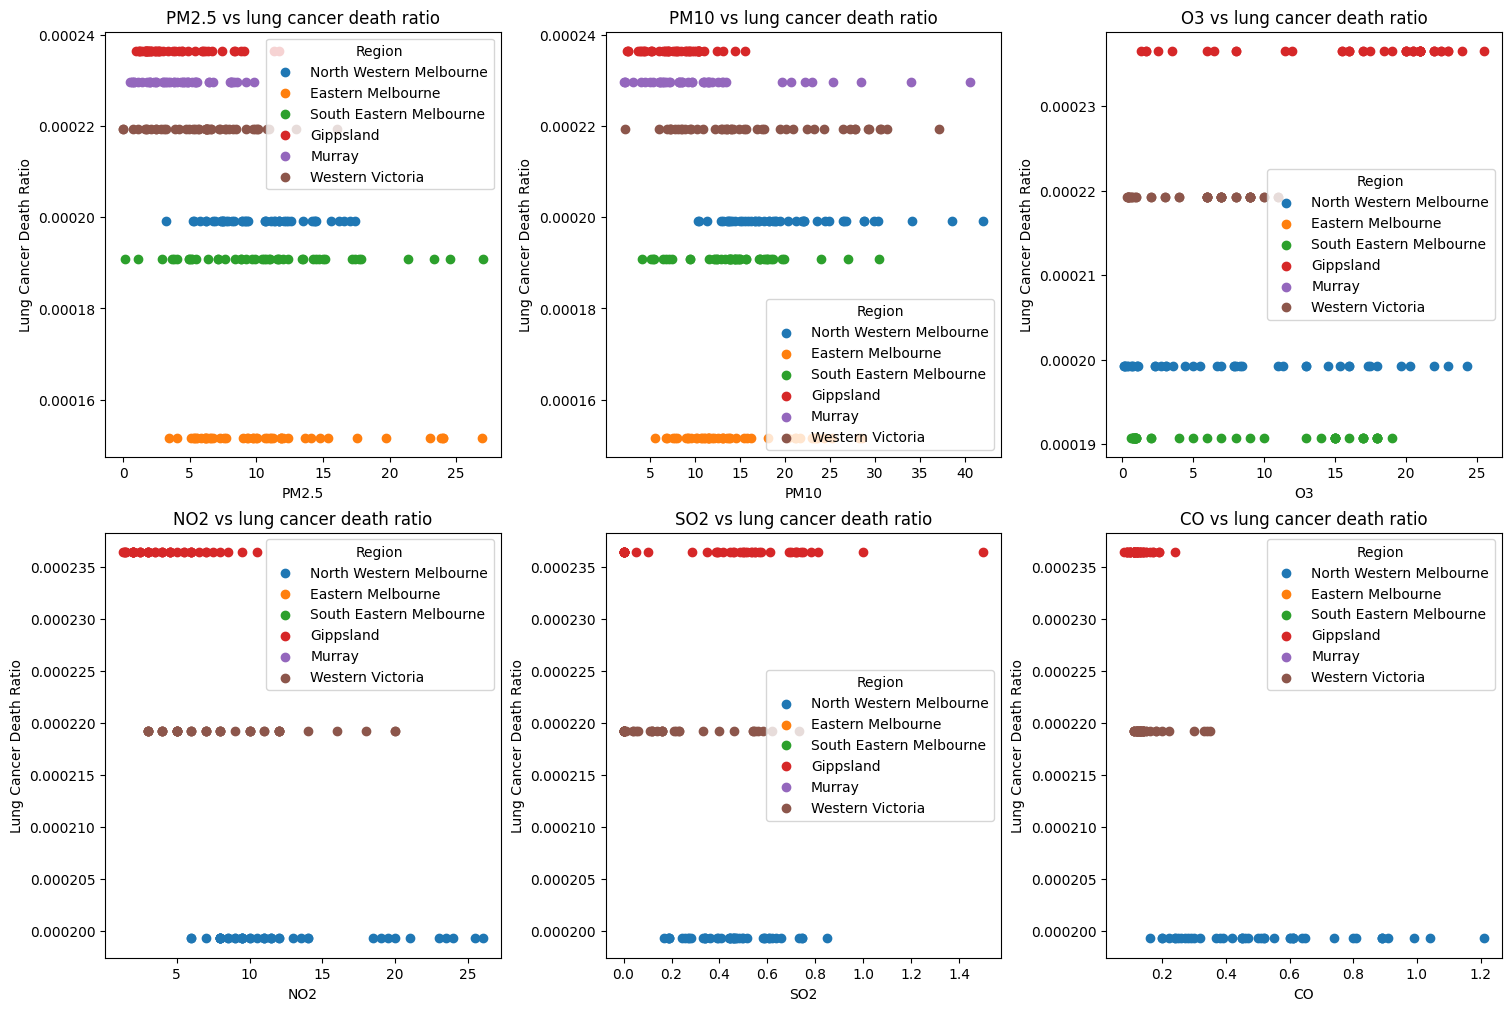

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.json_normalize(data)  

features = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
df.replace('None', np.nan, inplace=True)

# create a mapping of phn_code and phn_name 
phn_code_to_name = {row['phn_code']: row['phn_name'] for _, row in df.iterrows()}

for idx, feature in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    for phn_code in phn_codes:
        region_data = df[df['phn_code'] == phn_code]
        for row_idx, row in region_data.iterrows():
            if isinstance(row[feature], list):  
                y_values = [row['lung_death_ratio']] * len(row[feature])
                phn_name = phn_code_to_name.get(phn_code, 'Unknown')  
                ax.scatter(row[feature], y_values, label=phn_name)
    
    # Draw the scatter plot for each air pollutant
    ax.set_title(f'{feature} vs lung cancer death ratio')
    ax.set_xlabel(feature)
    ax.set_ylabel('Lung Cancer Death Ratio')
    ax.legend(title="Region")

plt.show()


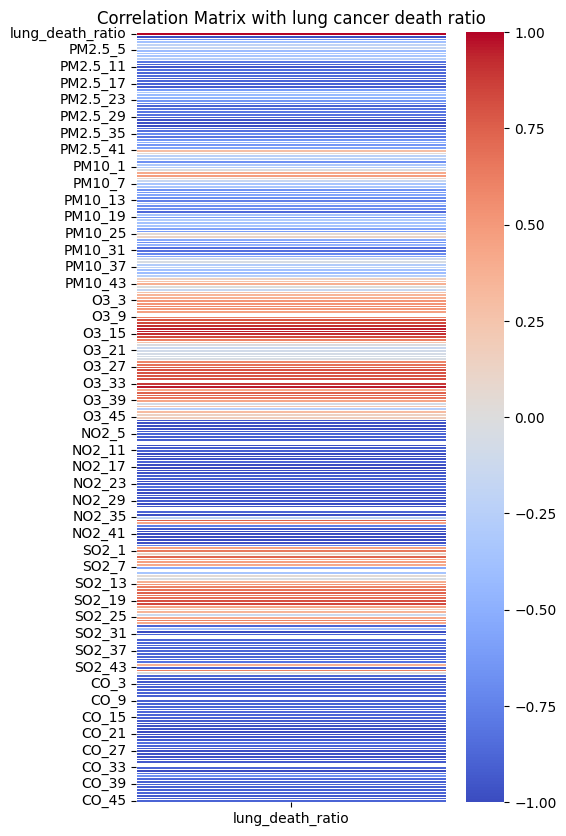

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.json_normalize(data) 


features = ['Particles', 'PM2.5', 'PM10', 'Visibility', 'API', 'O3', 'NO2', 'SO2', 'CO']

pollutant_features = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']


for feature in pollutant_features:
    # make all the values in the list be seperate columns in the dataframe
    df = pd.concat([df, df[feature].apply(pd.Series).add_prefix(feature+'_')], axis=1)


# Drop the original columns of features
df.drop(columns=features, inplace=True)

df = df.dropna(subset=df.columns[4:], how='all')

df = df.drop(columns=['_id','phn_code', 'phn_name','resp_death_ratio'])
correlation_matrix = df.corr()

# Draw the correlation matrix
plt.figure(figsize=(5, 10))
sns.heatmap(correlation_matrix[['lung_death_ratio']], annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix with lung cancer death ratio")
plt.show()

